In [1]:
import random

import heavy_tails as hevytail
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

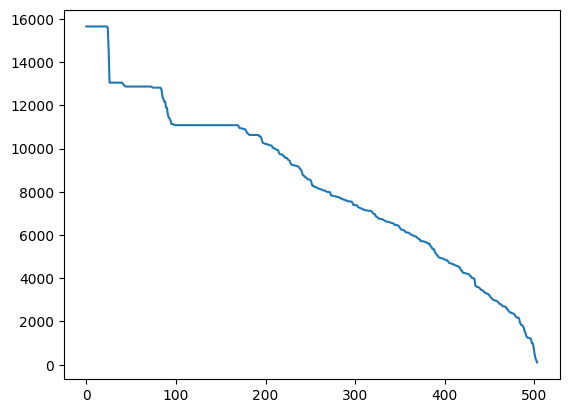

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
real_data = real_data.loc[:, np.all(~np.isnan(real_data), axis=0)]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")
print(f"Frist Date {real_data.index[0]:%Y-%m-%d}")
print(f"Last Date {real_data.index[-1]:%Y-%m-%d}")

Shape: (9216, 233)
Frist Date 1987-08-05
Last Date 2024-03-01


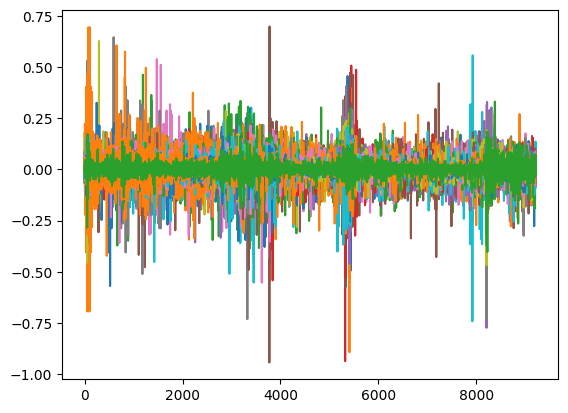

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data
np_log_price = np.cumsum(np_ret, axis=0)
plt.plot(np_ret)
plt.show()

Positive intercept -3.657505971361421
Positive slope -3.5248665022285697
Positive corr 0.9766161553323784
Intercept std over index 0.25062867823270635
Slope std over index 0.2160936025450152
Corr std over index 0.03468562517626274
Negative intercept -3.927544071096751
Negative slope -3.214216760974221
Negative corr 0.9733939618259404
Intercept std over index 0.3014419989198996
Slope std over index 0.24331391577930742
Corr std over index 0.03757521905738083


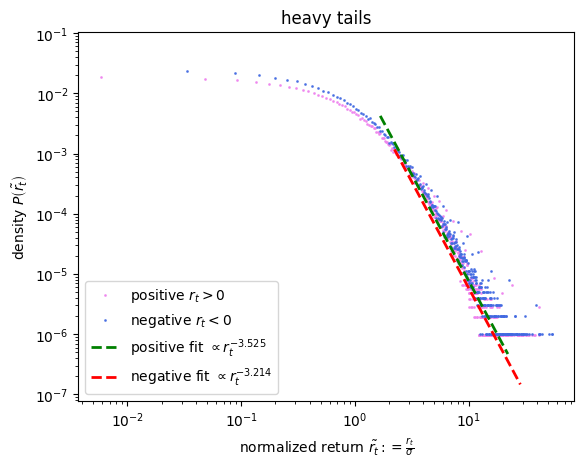

In [9]:
stat = hevytail.heavy_tails_stats(log_returns=np_ret, n_bins=1000)
pos_x, pos_y, pos_fit_x = stat["pos_bins"], stat["pos_dens"], stat["pos_powerlaw_x"]
pos_alpha, pos_beta, pos_r = stat["pos_const"], stat["pos_rate"], stat["pos_corr"]
pos_std_alpha, pos_std_beta, pos_std_r = (
    stat["pos_const_std"],
    stat["pos_rate_std"],
    stat["pos_corr_std"],
)

pos_x_lin = np.linspace(np.min(pos_fit_x), np.max(pos_fit_x), num=1000)
pos_y_lin = np.exp(pos_alpha) * np.power(pos_x_lin, pos_beta)

print(f"Positive intercept {pos_alpha}")
print(f"Positive slope {pos_beta}")
print(f"Positive corr {pos_r}")
print(f"Intercept std over index {pos_std_alpha}")
print(f"Slope std over index {pos_std_beta}")
print(f"Corr std over index {pos_std_r}")

neg_x, neg_y, neg_fit_x = stat["neg_bins"], stat["neg_dens"], stat["neg_powerlaw_x"]
neg_alpha, neg_beta, neg_r = stat["neg_const"], stat["neg_rate"], stat["neg_corr"]
neg_std_alpha, neg_std_beta, neg_std_r = (
    stat["neg_const_std"],
    stat["neg_rate_std"],
    stat["neg_corr_std"],
)

neg_x_lin = np.linspace(np.min(neg_fit_x), np.max(neg_fit_x), num=1000)
neg_y_lin = np.exp(neg_alpha) * np.power(neg_x_lin, pos_beta)

print(f"Negative intercept {neg_alpha}")
print(f"Negative slope {neg_beta}")
print(f"Negative corr {neg_r}")
print(f"Intercept std over index {neg_std_alpha}")
print(f"Slope std over index {neg_std_beta}")
print(f"Corr std over index {neg_std_r}")

plt.gca().set(**hevytail.heavy_tail_axes_setting)
plt.plot(pos_x, pos_y, **hevytail.heavy_tail_pos_plot_setting)
plt.plot(neg_x, neg_y, **hevytail.heavy_tail_neg_plot_setting)
plt.plot(
    pos_x_lin,
    pos_y_lin,
    label=f"positive fit $\propto r_t^{{{pos_beta:.3f}}}$",
    linewidth=2,
    linestyle="--",
    alpha=1,
    color="green",
)
plt.plot(
    neg_x_lin,
    neg_y_lin,
    label=f"negative fit $\propto r_t^{{{neg_beta:.3f}}}$",
    linewidth=2,
    linestyle="--",
    alpha=1,
    color="red",
)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/ht.png")
plt.show()